In [1]:
#Import Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import xarray as xr
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
from config import run_config

pd.options.mode.chained_assignment = None

#Autoreload changed local modules
%load_ext autoreload 
%autoreload 2

In [2]:
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
#base_project_dir = '/Users/agmeyer4/LAIR_1/'


#SLC SOURCES
slc_sources = dict(
    landfill = {'salt_lake_valley':{'lat':40.746,'lon':-112.042},
                 'trans_jordan':{'lat':40.55862,'lon':-112.053},
                 'davis':{'lat':41.114,'lon':-111.931},
                 'weber':{'lat':41.218,'lon':-111.99},
                 'bountiful':{'lat':40.911,'lon':-111.917}},
    ww_plant = {'central_valley':{'lat':40.7036613,'lon':-111.9141398},
                 'big_cottonwood':{'lat':40.6187424,'lon':-111.7824328},
                 'se_regional':{'lat':40.5411975,'lon':-111.8191652},
                 'south_valley':{'lat':40.5033357,'lon':-111.9187493},
                 'slc':{'lat':40.8030915,'lon':-111.9295899},
                 },
    refinery = {'Chevron':        {'lat':40.825,'lon':-111.924},
                  'Big West Oil':   {'lat':40.838,'lon':-111.920},
                  'Marathon':       {'lat':40.794,'lon':-111.909},
                  'Holly Refining': {'lat':40.887,'lon':-111.904},
                  'Silver Eagle':   {'lat':40.868,'lon':-111.910}}
    )

source_df = pd.DataFrame()
for sourcetype in slc_sources.keys():
    df = pd.DataFrame(slc_sources[sourcetype]).transpose()
    df['type'] = sourcetype
    source_df = pd.concat([source_df,df])

In [3]:
# config_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test/20230711/config'
# config_json_fname = os.listdir(config_path)[0]
# configs = run_config.run_config_obj(config_json_fname=config_json_fname) #load the configs
# stilt_name = '20230711'
# stilt_path = os.path.join(configs.folder_paths['stilt_folder'],stilt_name,'receptors')
# stilt_rec = ac.StiltReceptors(configs,path = stilt_path)# = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Atmos_Column/output/receptors/ground/20230711_100000_235959.csv')
# stilt_rec.load_receptors()

In [4]:
class StiltOutputHandler:
    def __init__(self,project_fullpath):
        self.project_fullpath = project_fullpath
        self.out_byid_fullpath = os.path.join(project_fullpath,'out','by-id')
        self.rec_path = os.path.join(project_fullpath,'receptors')
        config_path = os.path.join(project_fullpath,'config')
        config_json_fname = os.listdir(config_path)[0]
        self.configs = run_config.run_config_obj(config_json_fname=config_json_fname) #load the configs

    def load_stilt_rec(self):
        '''Create a receptor class for the given receptor CSV in the project directory
        
        Returns:
        stilt_rec (stilt_rec_handler object): stilt receptor class with metadata and df
        '''

        #Check to make sure there is only one receptor csv file in the folder
        if len(os.listdir(self.rec_path))>1:
            raise Exception(f'More than one receptor file in {self.rec_path}. Check the setup or amend this code')
        if len(os.listdir(self.rec_path))==0:
            raise Exception(f'No receptor csv files in {self.rec_path}. Check stilt setup.')
        rec_csv_name = os.listdir(self.rec_path)[0] #should only be one file in the dir, use that as the receptor file

        stilt_rec = ac.StiltReceptors(self.configs,path = self.rec_path)# = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Atmos_Column/output/receptors/ground/20230711_100000_235959.csv')
        stilt_rec.load_receptors()
        self.stilt_rec = stilt_rec #save it to the class

    def get_id_path(self,id):
        '''Gets the full path to the id folder given that id
        
        Args: 
        id (str): the simulation id corresponding with a folder in the "by-id" folder of the stilt out folder
        
        Returns:
        id_fullpath (str): string of the full path to the id subfolder
        '''

        id_fullpath = os.path.join(self.out_byid_fullpath,id)
        return id_fullpath

# all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test'
# stilt_name = '20230711'
# project_fullpath = os.path.join(all_stilt_path,stilt_name)
# my_stilt_output_handler = StiltOutputHandler(project_fullpath)
# my_stilt_output_handler.load_stilt_rec()
# my_stilt_output_handler.__dict__

In [5]:
class SingleFootprintLoader:
    def __init__(self,nc_fullpath):
        self.nc_fullpath = nc_fullpath
    
    def get_tsummed_ds(self):
        '''Main function to get a footprint dataset summed on time
        
        Returns:
        tsummed_df (xarray.DataSet): dataset of a single receptor footprint, summed on time
        '''
        ds = self.load_full_ds()
        tsummed_df = self.sum_on_time(ds)
        return tsummed_df

    def load_full_ds(self):
        '''Loads the full xarray dataset from an nc footprint file
        
        Returns:
        ds (xarray.DataSet): dataset containing the full footprint, as output by STILT
        '''

        ds = xr.open_dataset(self.nc_fullpath)
        return ds
    
    def sum_on_time(self,ds):
        '''Sum over the time variable of a footprint dataset
        
        Args:
        ds (xarray.DataSet): dataset containing the full footprint including a time dimension, as output by STILT when timesum is off. 

        Returns:
        sum_ds (xarray.DataSet): dataset containing the time summed footprint
        '''

        sum_ds = ds.sum(dim='time')
        return sum_ds

# all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test'
# stilt_name = '20230711'
# project_fullpath = os.path.join(all_stilt_path,stilt_name)
# my_stilt_output_handler = StiltOutputHandler(project_fullpath)
# my_stilt_output_handler.load_stilt_rec()
# singtime_recdf = my_stilt_output_handler.stilt_rec.split_dfs[0]

# i = 0

# id_str = str(singtime_recdf.iloc[i]['sim_id'])
# nc_fullpath = os.path.join(all_stilt_path,stilt_name,'out','by-id',id_str,f'{id_str}_foot.nc')
# sing_foot = SingleFootprintLoader(nc_fullpath)
# sing_foot.get_tsummed_ds()

In [6]:
class TimegroupFootprintHandler:
    def __init__(self,split_rec_df,out_byid_fullpath,sim_id_dim_map):
        self.split_rec_df = split_rec_df
        self.out_byid_fullpath = out_byid_fullpath
        self.sim_id_dim_map = sim_id_dim_map
        self.check_and_add_time()

    def check_and_add_time(self):
        '''Check to make sure that the split_rec_df is only one run_time (this class meant to only accept singletimes). And add that time as an attr
        '''

        if len(self.split_rec_df.groupby('run_times'))>1:
            raise ValueError('The input split_rec_df has more than one runtime included')
        else:
            self.run_time = self.split_rec_df.iloc[0]['run_times']

    def get_full_ds(self):
        '''Retrieve all of the footprints for the receptors in the split_rec_df using sing_stiltfoot_loader
        
        Args:
        sim_id_mapdict (dict): a dictionary of form {'new_dim_name':val,'id_map':{[sim_ids]:[map_to_val]}}. 'new_dim_name' is the name of the new dimension
                                'id_map' is a dictionary where the keys are the sim_ids, and map_to_val are the values for the new dim that the sim_ids should 
                                map to, such that the new dimension will have new_dim_name and values map_to_val, corresponding to each sim_id in the dict
                                
        Returns:
        combined_ds (xarray.Dataset): an xarray dataset with three dims and coords (lat, lon, new_dim_name) and one data variable (foot)
        '''

        tsummed_foots = self.get_tsummed_foots() #get the timesummed footprint dictionary, with keys = sim_ids and values = single datasets of footprints with lat/lon dim/coords
        
        datasets = list(tsummed_foots.values()) #create a list of the datasets for concatenation
        sim_ids = list(tsummed_foots.keys()) #create a list of the sim_ids (keys of tsummed_foots) to transform the new dim/coords

        combined_ds = xr.concat(datasets,dim=self.sim_id_dim_map['new_dim_name']) #concat the dataset with the new dim

        new_dim_values = [self.sim_id_dim_map['id_map'][sim_id]for sim_id in sim_ids] #map the new dimension values based on the sim ids and the id_map from the sim_id_mapdict
        combined_ds = combined_ds.assign_coords({self.sim_id_dim_map['new_dim_name']:new_dim_values}) #associate coordinates with the new dim, using the values from the id_map

        return combined_ds
    
    def get_tsummed_foots(self):
        '''Get a dictionary of footprints for a single time group. This contains all of the data for that timegroup, in dictionary form
        
        Returns:
        tsummed_foots (dict) : a dictionary with keys = sim_id and values = a single time summed dataset for that sim_id
        '''

        tsummed_foots = {}  #initialize the dict
        for index,row in self.split_rec_df.iterrows(): #loop through the split_rec_df to find the footprints we need for this timegroup
            sim_id = row['sim_id'] #get the sim_id from the row
            nc_fullpath = os.path.join(self.out_byid_fullpath,str(sim_id),f'{sim_id}_foot.nc') #get the location of the footprint nc file
            try: #put in a try statement in case there is no nc file for that sim_id
                sing_foot = SingleFootprintLoader(nc_fullpath) #create the footprint loader
                ds = sing_foot.get_tsummed_ds() #get the xarray dataset for that single footprint
                tsummed_foots[sim_id] = ds #add it to the dictionary
            except FileNotFoundError: #if there is no nc file, we hit this
                tsummed_foots[sim_id] = xr.zeros_like(ds)
                #raise FileNotFoundError('No nc file for that sim_id. Need to deal with this error.')
        return tsummed_foots
    
    def create_weighting_dict(self,weight_func):
        return weight_func(self.sim_id_dim_map)
    
    def combine_and_weight(self,weight_func):
        combined_ds = self.get_full_ds()
        weighting_dict = self.create_weighting_dict(weight_func)
        combined_ds['foot_x_wgt'] = combined_ds['foot'] * xr.DataArray(list(weighting_dict.values()),dims=self.sim_id_dim_map['new_dim_name'])
        return combined_ds
    
    def sum_on_level(self,combined_ds):
        summed_ds = combined_ds.sum(dim=self.sim_id_dim_map['new_dim_name'])
        return summed_ds
    
class WeightingFunctions:
    def __init__(self):
        pass
    
    def equal_weight(sim_id_dim_map):
        dim_vals = sim_id_dim_map['id_map'].values()
        num_levels = len(sim_id_dim_map['id_map'])
        weighting_dict = {}
        for dim_val in dim_vals:
            weighting_dict[dim_val] = 1/num_levels
        return weighting_dict   
    
    def eq_to_dim(sim_id_dim_map):
        weighting_dict = {}
        for dim_val in sim_id_dim_map['id_map'].values():
            weighting_dict[dim_val] = dim_val
        return weighting_dict

# all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test'
# stilt_name = '20230711'
# project_fullpath = os.path.join(all_stilt_path,stilt_name)
# my_stilt_output_handler = StiltOutputHandler(project_fullpath)
# my_stilt_output_handler.load_stilt_rec()
# split_rec_df = my_stilt_output_handler.stilt_rec.split_dfs[0]

# sim_id_dim_map = {'new_dim_name':'zail',
#                   'id_map':dict(zip(split_rec_df['sim_id'],split_rec_df['zail']))}

# out_byid_fullpath = os.path.join(all_stilt_path,stilt_name,'out','by-id')
# timegrp_foot = TimegroupFootprintHandler(split_rec_df,out_byid_fullpath,sim_id_dim_map)
# combined_ds = timegrp_foot.combine_and_weight(WeightingFunctions.equal_weight)
# summed_ds = timegrp_foot.sum_on_level(combined_ds)


In [13]:
all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test'
stilt_name = '20230728'
project_fullpath = os.path.join(all_stilt_path,stilt_name)
my_stilt_output_handler = StiltOutputHandler(project_fullpath)
my_stilt_output_handler.load_stilt_rec()

stilt_rec = my_stilt_output_handler.stilt_rec

summed_ds_ts = {}
for split_rec_df in stilt_rec.split_dfs:

    sim_id_dim_map = {'new_dim_name':'zail',
                    'id_map':dict(zip(split_rec_df['sim_id'],split_rec_df['zail']))}

    out_byid_fullpath = os.path.join(all_stilt_path,stilt_name,'out','by-id')
    timegrp_foot = TimegroupFootprintHandler(split_rec_df,out_byid_fullpath,sim_id_dim_map)
    combined_ds = timegrp_foot.combine_and_weight(WeightingFunctions.equal_weight)
    summed_ds = timegrp_foot.sum_on_level(combined_ds)
    summed_ds_ts[timegrp_foot.run_time] = summed_ds

In [7]:
all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test'
stilt_name = '20230728'
project_fullpath = os.path.join(all_stilt_path,stilt_name)
my_stilt_output_handler = StiltOutputHandler(project_fullpath)
my_stilt_output_handler.load_stilt_rec()

stilt_rec = my_stilt_output_handler.stilt_rec
split_rec_df = stilt_rec.split_dfs[3]

sim_id_dim_map = {'new_dim_name':'zail',
                'id_map':dict(zip(split_rec_df['sim_id'],split_rec_df['zail']))}

out_byid_fullpath = os.path.join(all_stilt_path,stilt_name,'out','by-id')
timegrp_foot = TimegroupFootprintHandler(split_rec_df,out_byid_fullpath,sim_id_dim_map)
combined_ds = timegrp_foot.combine_and_weight(WeightingFunctions.equal_weight)
summed_ds = timegrp_foot.sum_on_level(combined_ds)

In [16]:
combined_ds.zail

<xarray.DataArray 'zail' (zail: 11)> Size: 88B
array([   0,  250,  500,  750, 1000, 1250, 1500, 1750, 2000, 2250, 2500])
Coordinates:
  * zail     (zail) int64 88B 0 250 500 750 1000 1250 1500 1750 2000 2250 2500

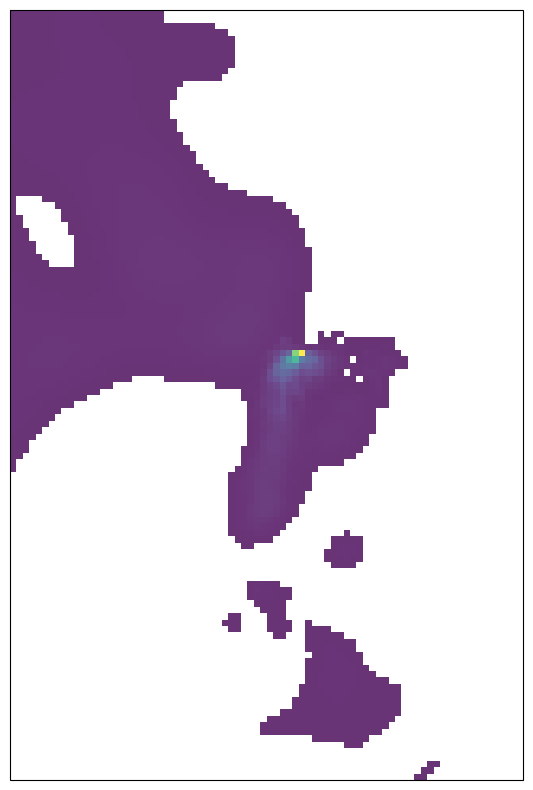

In [15]:
extent=[-112.3,-111.5,40.1,41.3]
proj = ccrs.PlateCarree()


fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent(extent,crs=proj)
foot = summed_ds['foot_x_wgt']

#foot = combined_ds.isel(zail=i)['foot']
masked_foot = foot.where(foot>0.00005)
masked_foot.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.8)
plt.show()
fig.savefig('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/stilt_footprint_pngs/for_fig/summed.png',dpi = 500,bbox_inches = 'tight')

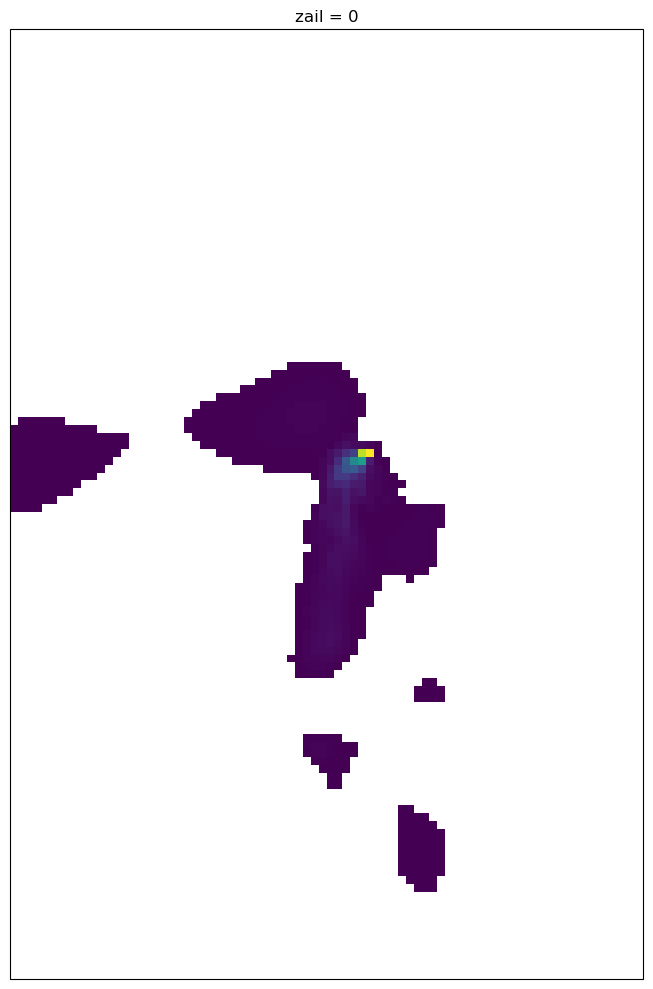

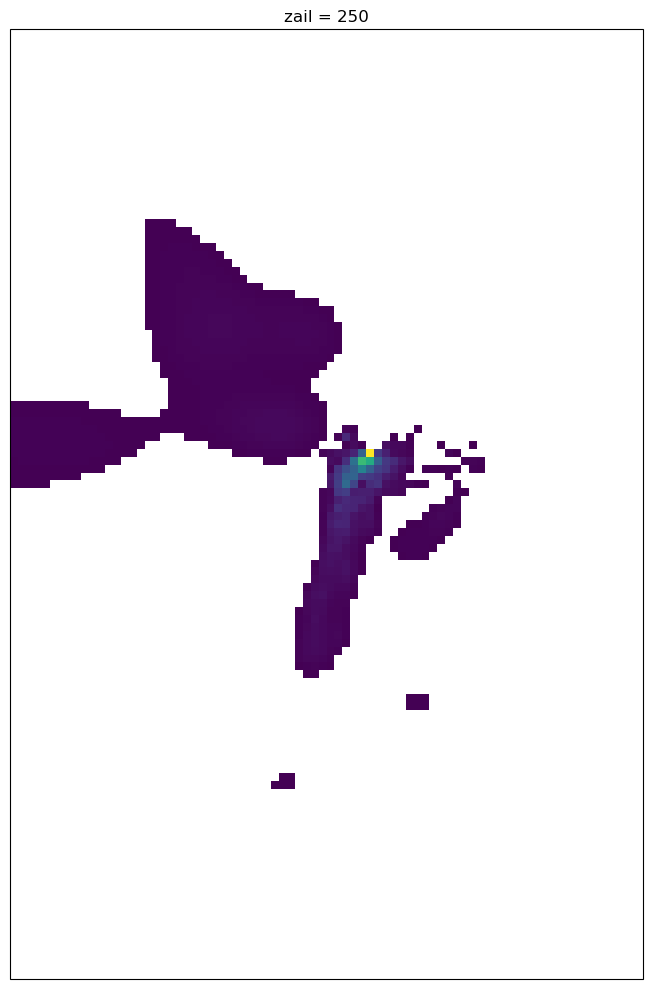

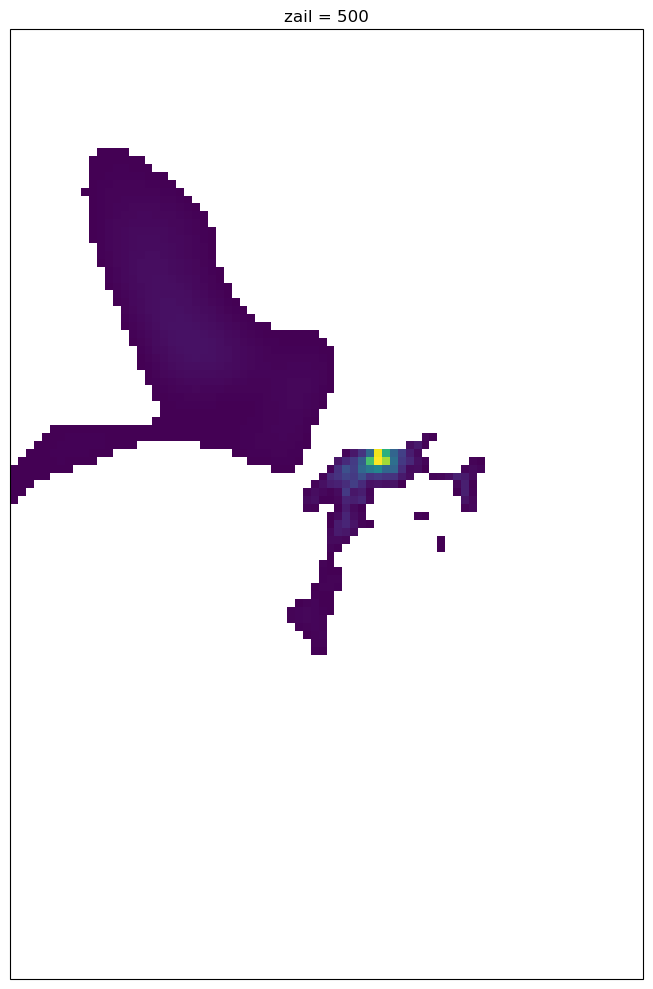

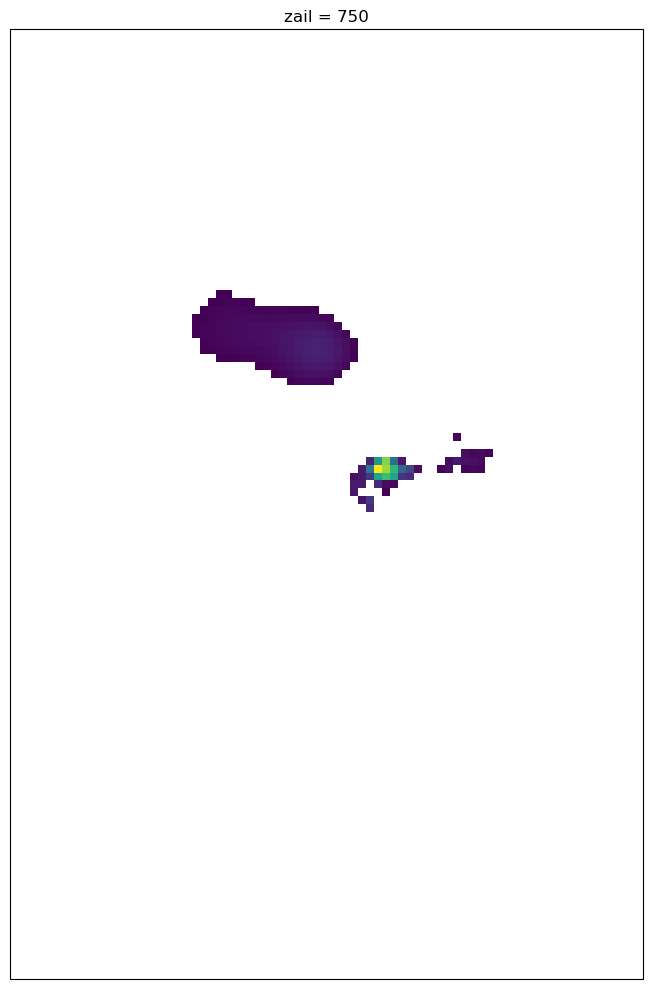

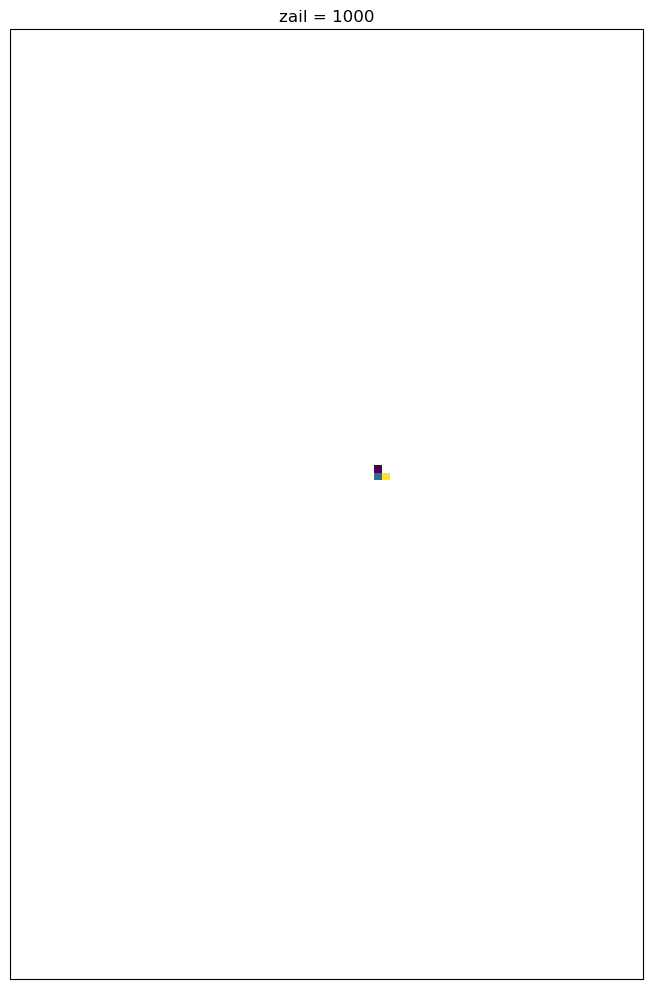

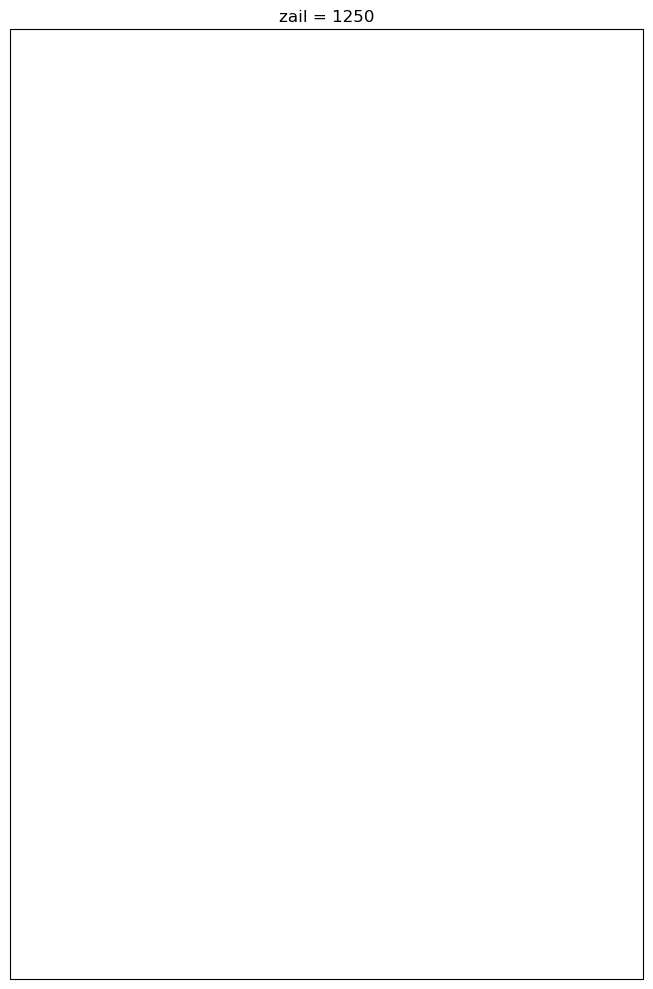

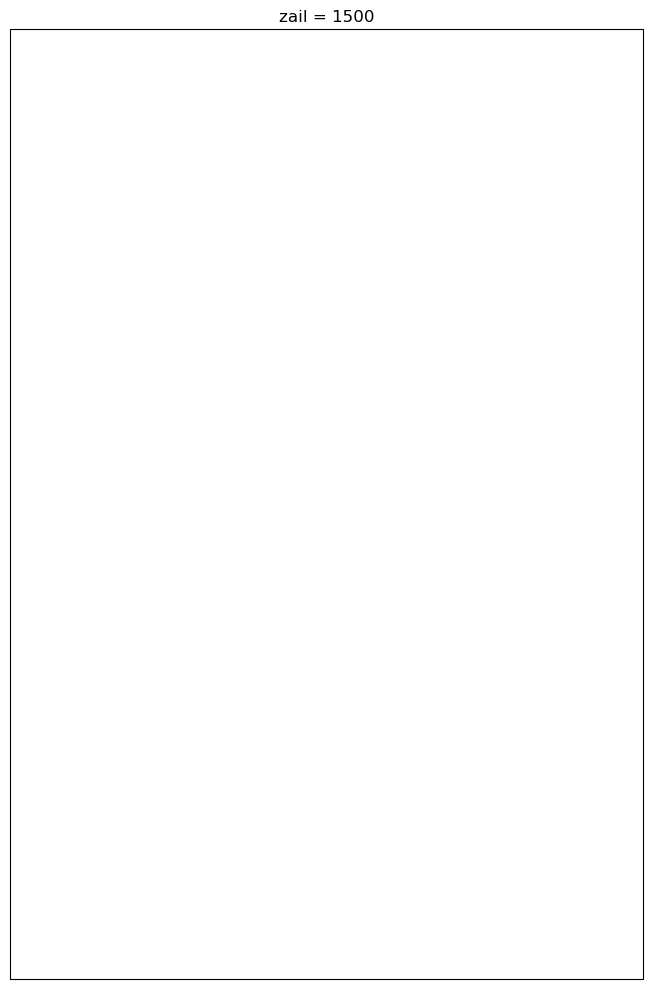

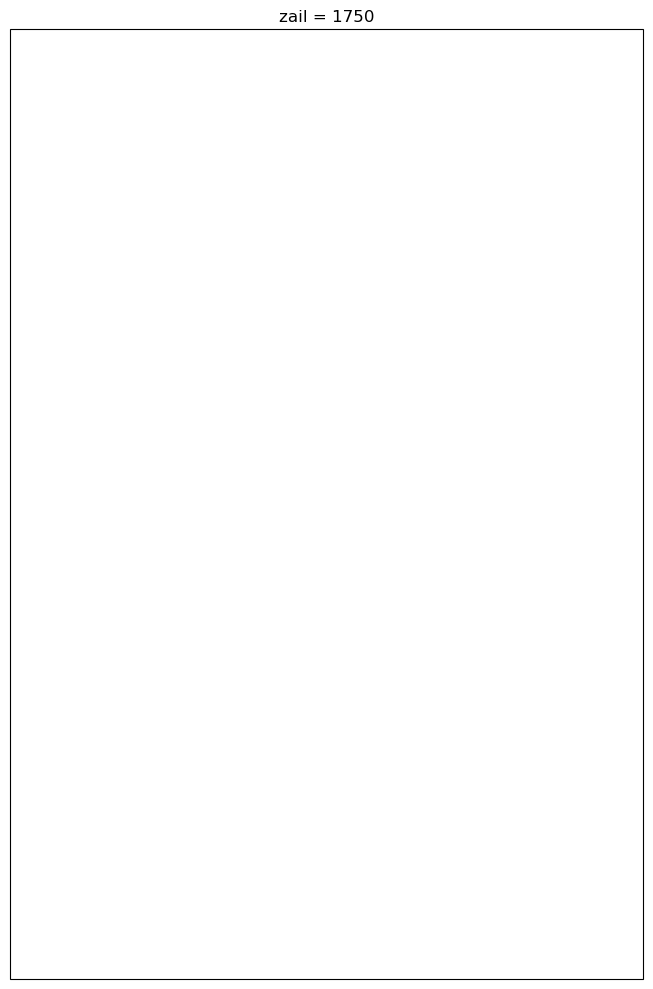

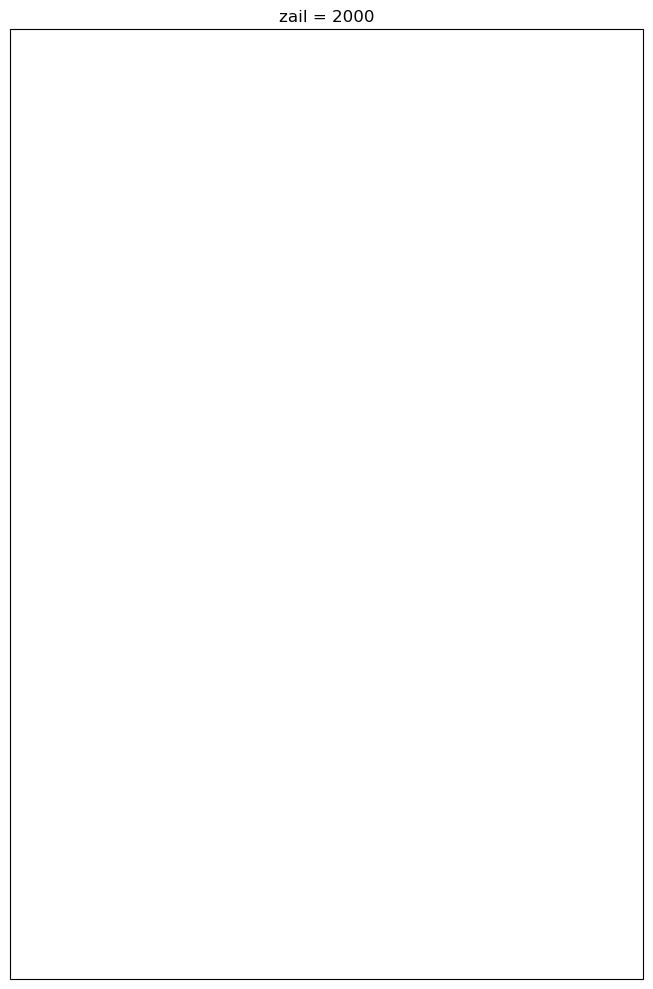

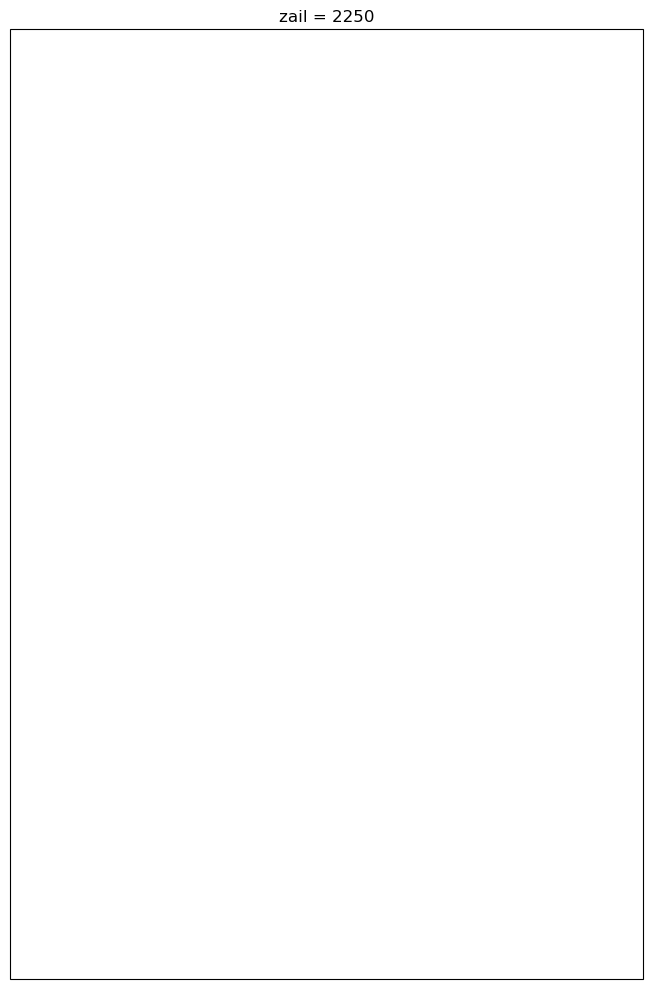

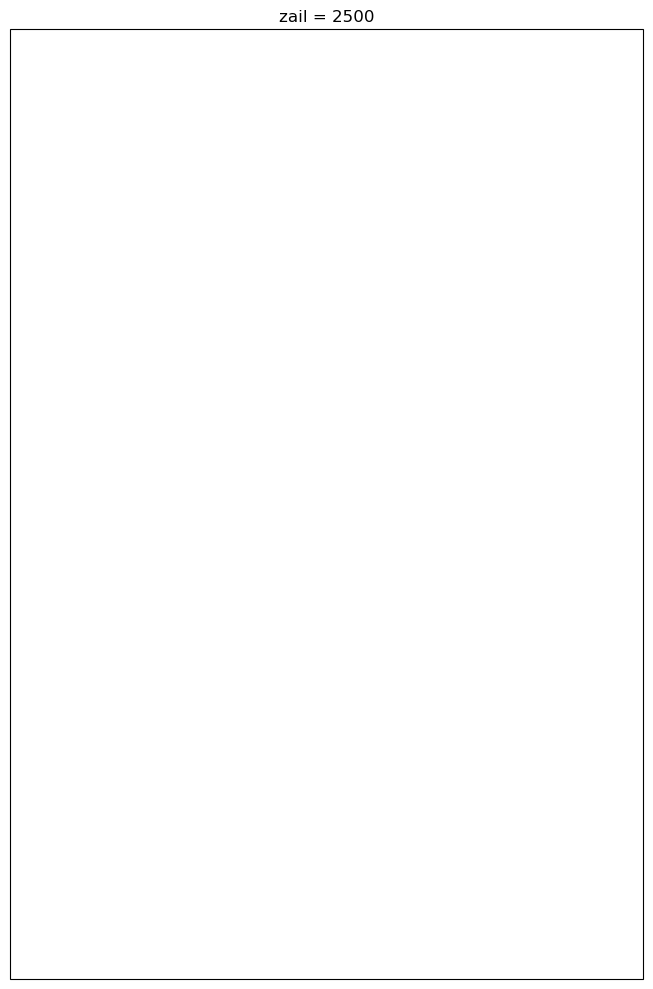

In [17]:
extent=[-112.3,-111.5,40.1,41.3]
proj = ccrs.PlateCarree()

for i in range(len(combined_ds.zail)):

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)
        
    foot = combined_ds.isel(zail=i)['foot_x_wgt']
    masked_foot = foot.where(foot>0.00005)
    masked_foot.plot(ax=ax,transform=proj,add_colorbar=False)
    fig.tight_layout()
    plt.show()

In [ ]:
fig_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/stilt_footprint_pngs/for_fig'

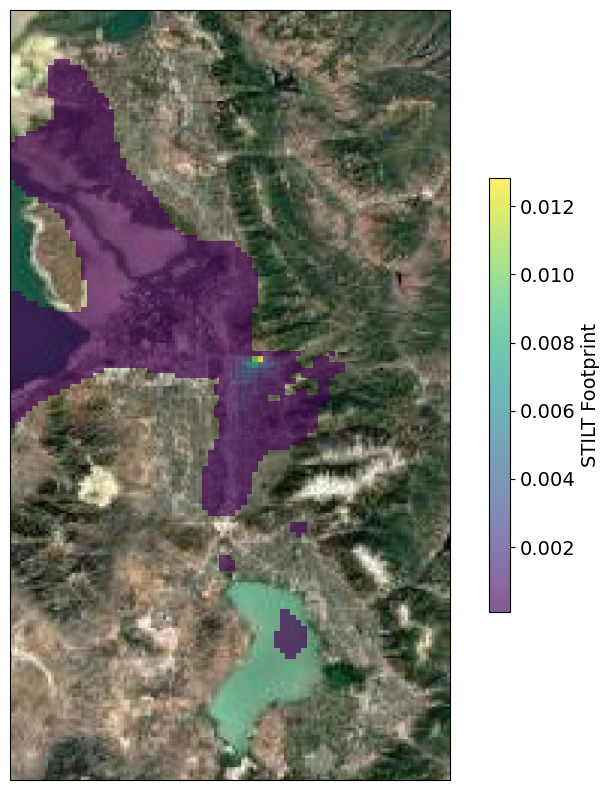

In [11]:

inst_lat = 40.766
inst_lon = -111.847
labsize = 14
zoom = 2
proj = ccrs.PlateCarree()
request = cimgt.GoogleTiles(style='satellite')
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
min_foot = 0.0001

extent=[-112.3,-111.5,40.0,41.4]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent(extent,crs=proj)

ax.add_image(request,int(scale))
foot = summed_ds['foot_x_wgt']
masked_foot = foot.where(foot>min_foot)
footplot = masked_foot.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
cbar = plt.colorbar(footplot,fraction=0.028)
cbar.ax.tick_params(labelsize=labsize)
cbar.set_label(label = 'STILT Footprint',size=labsize)

#plt.title(run_time)
#plt.gcf().autofmt_xdate()
plt.show()


In [61]:
import pickle
import matplotlib.dates as mdates
import datetime

pickle_path = f'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/Pickled_files/ratio_v2/ha'

fname = 'ha_20230814_fulldf.pkl'
with open(os.path.join(pickle_path,fname), 'rb') as handle:
    resampled_day_df_regr = pickle.load(handle)

inst_id = 'ha'
pickle_path = f'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/Pickled_files/ratio_v2/{inst_id}'

fname = 'daily_regr_details.pkl'
with open(os.path.join(pickle_path,fname), 'rb') as handle:
    daily_regr_details = pickle.load(handle)
fname = 'good_grouped_periods_fulldfs.pkl'
with open(os.path.join(pickle_path,fname), 'rb') as handle:
    good_grouped_periods_fulldfs = pickle.load(handle)


def thresh_ratio_df(df,regr_label,r2_thresh,nobs_thresh):
    cols = [col for col in df.columns if regr_label in col]
    ndf = df[cols]
    mask = (ndf[f'{regr_label}_r2']>r2_thresh)&(ndf[f'{regr_label}_nobs']>=nobs_thresh)
    return ndf[mask]

def annotate_rr_sumaries(rolling_ratio_summary,regr_label,permil = True,keys_to_include = ['tot_ratios','good_ratios','slope_mean','slope_std']):
    text = regr_label + '\n'
    for k,v in rolling_ratio_summary.items():
        if k not in keys_to_include:
            continue
        if 'slope' in k:
            if permil:
                v = v*1000
            v = "{0:.3g}".format(v)
            if permil:
                v = v+"$^o/_{oo}$"
        text = f'{text} {k} = {v}\n'
    return text

def get_regression(df_window,dt,x_var,y_var):
    linregress_result = regress2(df_window[x_var],df_window[y_var])
    return dict(dt = dt,
                dt_range = [df_window.iloc[0].name,df_window.iloc[-1].name],
                slope=linregress_result['slope'],
                r2=linregress_result['r']**2,
                nobs=int(len(df_window)))

def find_grouped_periods(df,grouped_tdelta_thresh,nratio_good_thresh):
    deltas = df.index.diff()
    dt_groups = []
    for i in range(len(df)):
        dt = df.iloc[i].name
        delta = deltas[i]
        if i == 0:
            dt_groups.append([dt])
            continue
        if delta <= grouped_tdelta_thresh:
            dt_groups[-1].append(dt)
        else:
            dt_groups.append([dt])

    grouped_periods = []
    for dt_group in dt_groups:
        if len(dt_group) >= nratio_good_thresh:
            grouped_periods.append(dict(dt1 = dt_group[0],
                                            dt2 = dt_group[-1],
                                            n_good = len(dt_group)))

    return grouped_periods

def trim_df_by_dtidx(df,dt1,dt2):
    outdf = df.loc[(df.index>=dt1)&(df.index<=dt2)]
    return outdf

def resample_met_df(met_df,interval):
    outdf = met_df.copy()
    outdf = outdf[['pres','temp','rh','u','v']].resample(interval).mean(numeric_only = True)
    outdf['ws'],outdf['wd'] = np.vectorize(ac.uv_to_wdws)(outdf['u'],outdf['v'])
    return outdf

def ratio_ts_plot(ax,regr_label,dt):
    if regr_label in ['ch4_co2','co_co2']:
        permil=True
    else:
        permil=False
    gooddf = thresh_ratio_df(resampled_day_df_regr,regr_label,regr_details['r2_good_thresh'],regr_details['nobs_good_thresh'])
    baddf = resampled_day_df_regr[~resampled_day_df_regr.index.isin(gooddf.index)]
    if permil:
        scatter = ax.scatter(
                gooddf.index,
                gooddf[f'{regr_label}_slope']*1000,
                s=20,
                c=gooddf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors = 'red'
            ) 
        scatter = ax.scatter(
                baddf.index,
                baddf[f'{regr_label}_slope']*1000,
                s=20,
                c=baddf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors='grey'
            ) 
    else:
        scatter = ax.scatter(
                gooddf.index,
                gooddf[f'{regr_label}_slope'],
                s=20,
                c=gooddf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors = 'red'
            ) 
        scatter = ax.scatter(
                baddf.index,
                baddf[f'{regr_label}_slope'],
                s=20,
                c=baddf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors='grey'
            ) 
        
    for period in regr_details['regr_ratios'][regr_label]['grouped_periods']:
        ax.axvspan(period['dt1'],period['dt2'],color = 'yellow',alpha = 0.3)
        window_df = trim_df_by_dtidx(resampled_day_df_regr,period['dt1'],period['dt2'])
        slope_mean = window_df[f'{regr_label}_slope'].mean()
        slope_std = window_df[f'{regr_label}_slope'].std()
        if permil:
            text = "{0:.3g}".format(slope_mean*1000) + "$^o/_{oo}$\n" +"+/-{0:.3g}".format(slope_std*1000)+"$^o/_{oo}$"
        else:
            text = '{0:.3g}\n+/-{1:.3g}'.format(slope_mean,slope_std)

        ymin,ymax = ax.get_ylim()
        ax.annotate(text,(period['dt1'],ymin),verticalalignment='bottom')

    ax.tick_params(labelsize=labsize)
    if permil:
        ax.set_ylabel(f'{regr_label}_slope'+"$^o/_{oo}$", size=labsize)
    else:
        ax.set_ylabel(f'{regr_label}_slope', size=labsize)

    ax.axvline(dt,color = 'blue',linewidth = 4)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz=resampled_day_df_regr.index.tz))
    ax.set_xlabel(datetime.datetime.strftime(resampled_day_df_regr.index[0], '%Y-%m-%d %Z'), size=labsize)

    #ax.spines['top'].set_visible(False)
    #for label in ax.get_xticklabels():
    #    label.set_visible(False)
    #ax.set_xlabel('')
    #ax.set_xlim(xlims)
    return scatter

In [62]:
regr_details = daily_regr_details['2023-08-14'].copy()
labsize = 14

In [63]:
figures_path = os.path.join(base_project_dir,'Figures/stilt_footprint_pngs/new_stilt')

inst_lat = 40.766
inst_lon = -111.847
labsize = 14
zoom = 2
proj = ccrs.PlateCarree()
request = cimgt.GoogleTiles(style='satellite')
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
min_foot = 0.0001

#sim_id = 0
for run_time,summed_ds in summed_ds_ts.items():
    extent=[-112.3,-111.5,40.5,41.0]

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    ax.add_image(request,int(scale))
    foot = summed_ds['foot_x_wgt']
    masked_foot = foot.where(foot>min_foot)
    footplot = masked_foot.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(footplot,fraction=0.028)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint',size=labsize)

    axin1 = ax.inset_axes([0, 0, 0.4, 0.3])
    scatter = ratio_ts_plot(axin1,'ch4_co2',run_time.tz_convert('US/Mountain'))

    plt.title(run_time.tz_convert('US/Mountain'))
    plt.gcf().autofmt_xdate()
    #plt.show()
    
    fname = f"{run_time.strftime('%Y%m%d_%H')}.png"
    fig.savefig(os.path.join(figures_path,fname))
    plt.close()

In [ ]:
all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/test'
stilt_name = '20230712'
project_fullpath = os.path.join(all_stilt_path,stilt_name)
my_stilt_output_handler = StiltOutputHandler(project_fullpath)
my_stilt_output_handler.load_stilt_rec()

stilt_rec = my_stilt_output_handler.stilt_rec

summed_ds_ts = {}
for split_rec_df in stilt_rec.split_dfs:

    sim_id_dim_map = {'new_dim_name':'zail',
                    'id_map':dict(zip(split_rec_df['sim_id'],split_rec_df['zail']))}

    out_byid_fullpath = os.path.join(all_stilt_path,stilt_name,'out','by-id')
    timegrp_foot = TimegroupFootprintHandler(split_rec_df,out_byid_fullpath,sim_id_dim_map)
    combined_ds = timegrp_foot.combine_and_weight(WeightingFunctions.equal_weight)
    summed_ds = timegrp_foot.sum_on_level(combined_ds)
    summed_ds_ts[timegrp_foot.run_time] = summed_ds

In [ ]:
inst_lat = 40.766
inst_lon = -111.847
labsize = 14
zoom = 2
proj = ccrs.PlateCarree()
request = cimgt.GoogleTiles(style='satellite')
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
min_foot = 0.0001

#sim_id = 0
for run_time,summed_ds in summed_ds_ts.items():
    extent=[-112.3,-111.5,40.5,41.0]

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    ax.add_image(request,int(scale))
    foot = summed_ds['foot_x_wgt']
    masked_foot = foot.where(foot>min_foot)
    footplot = masked_foot.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(footplot,fraction=0.028)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint',size=labsize)

    plt.title(run_time)
    plt.gcf().autofmt_xdate()
    plt.show()